## Image classification with Convolutional Neural Networks

Based on the fastai (older 2017/2018?) course notebook Cats vs. Dogs. Some of the explanations are from there, some are added by me.

I use the fastai approach to classify pictures with elephants and rhinos.
Images where obtained by using Google Image Downloader, a python Script for 'searching' and 'downloading' Google images to the local hard disk (https://github.com/hardikvasa/google-images-download).

The collected dataset is fairly modest in size with 167 training images (split further to train and validation sets) and about 30 test images. So, transfer learning plays a big part.

Unsurprisingly, we're going to use convolutional neural networks (CNNs) to allow our computer to see - something that is only possible thanks to deep learning.

## Elephants vs Rhinos

In [338]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# autoreload reloads modules automatically before entering the execution of code typed at the IPython prompt.
# value 2: Reload all modules (except those excluded by %aimport) every time before executing the Python code typed

In [339]:
# This notebook is based on the old version of the fastai (0.7). Fastai upgrade to 1.0 changed things quite a bit.
# Setting up suitable env with the older version:
!pip install fastai==0.7.0 --no-deps
!pip install torch==0.4.1 torchvision==0.2.1

Here we import the libraries we need

In [340]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [341]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

Take a quick look into the data folders:

In [342]:
!pwd
!ls ../input/elerhin2

/kaggle/working
test  train


In [343]:
# Test dataset is here:
!ls ../input/elerhin2/test/test

elephant (76).jpg  elephant (83).jpg  elephant (90).jpg  rhino (82).jpg
elephant (77).jpg  elephant (84).jpg  rhino (76).jpg	 rhino (83).jpg
elephant (78).jpg  elephant (85).jpg  rhino (77).jpg	 rhino (84).jpg
elephant (79).jpg  elephant (86).jpg  rhino (78).jpg	 rhino (85).jpg
elephant (80).jpg  elephant (87).jpg  rhino (79).jpg	 rhino (86).jpg
elephant (81).jpg  elephant (88).jpg  rhino (80).jpg
elephant (82).jpg  elephant (89).jpg  rhino (81).jpg


In [344]:
# Train is here
!ls ../input/elerhin2/train/train

elephant (1).gif   elephant (41).jpg  rhino (1).png   rhino (43).jpg
elephant (1).jpg   elephant (42).jpg  rhino (10).jpg  rhino (44).jpg
elephant (1).png   elephant (43).jpg  rhino (11).jpg  rhino (45).jpg
elephant (10).jpg  elephant (44).jpg  rhino (12).jpg  rhino (46).jpg
elephant (11).jpg  elephant (45).jpg  rhino (13).jpg  rhino (47).jpg
elephant (12).jpg  elephant (46).jpg  rhino (14).jpg  rhino (48).jpg
elephant (13).jpg  elephant (47).jpg  rhino (15).jpg  rhino (49).jpg
elephant (14).jpg  elephant (48).jpg  rhino (16).jpg  rhino (5).jpg
elephant (15).jpg  elephant (49).jpg  rhino (17).jpg  rhino (5).png
elephant (16).jpg  elephant (5).jpg   rhino (18).jpg  rhino (50).jpg
elephant (17).jpg  elephant (50).jpg  rhino (19).jpg  rhino (51).jpg
elephant (18).jpg  elephant (51).jpg  rhino (2).jpeg  rhino (52).jpg
elephant (19).jpg  elephant (52).jpg  rhino (2).jpg   rhino (53).jpg
elephant (2).gif   elephant (53).jpg  rhino (2).png   rhino (54).jpg
elephant (2).jpg   elephant (54).jpg

In [345]:
# How many files in each?
len(os.listdir("../input/elerhin2/train/train")), len(os.listdir("../input/elerhin2/test/test"))

(167, 26)

Below, `PATH` is the path to your data. `sz` is the size that the images will be resized to in order to ensure that the training runs quickly. Leave it at `224` for now.

In [346]:
# Path to test elephant vs rhino
PATH = "../input/elerhin2/"

TMP_PATH = "/tmp/tmp"
MODEL_PATH = "/tmp/model/"
sz=224   # size of image ( 224 x 224). Images are resized to this size.

It's important that you have a working NVidia GPU set up. The programming framework used to behind the scenes to work with NVidia GPUs is called CUDA. Therefore, you need to ensure the following line returns `True` before you proceed. If you have problems with this, please check the FAQ and ask for help on [the forums](http://forums.fast.ai).

In [347]:
torch.cuda.is_available()

True

In addition, NVidia provides special accelerated functions for deep learning in a package called CuDNN. Although not strictly necessary, it will improve training performance significantly, and is included by default in all supported fastai configurations. Therefore, if the following does not return `True`, you may want to look into why.

In [348]:
torch.backends.cudnn.enabled

True

## First look at the pictures

In [349]:
os.listdir(PATH)   # Return a list containing the names of the files (or directories) in the directory.

['test', 'train']

In [350]:
sorted(os.listdir(f'{PATH}train/train'))

['elephant (1).gif',
 'elephant (1).jpg',
 'elephant (1).png',
 'elephant (10).jpg',
 'elephant (11).jpg',
 'elephant (12).jpg',
 'elephant (13).jpg',
 'elephant (14).jpg',
 'elephant (15).jpg',
 'elephant (16).jpg',
 'elephant (17).jpg',
 'elephant (18).jpg',
 'elephant (19).jpg',
 'elephant (2).gif',
 'elephant (2).jpg',
 'elephant (2).png',
 'elephant (20).jpg',
 'elephant (21).jpg',
 'elephant (22).jpg',
 'elephant (23).jpg',
 'elephant (24).jpg',
 'elephant (25).jpg',
 'elephant (26).jpg',
 'elephant (27).jpg',
 'elephant (28).jpg',
 'elephant (29).jpg',
 'elephant (3).gif',
 'elephant (3).jpg',
 'elephant (3).png',
 'elephant (30).jpg',
 'elephant (31).jpg',
 'elephant (32).jpg',
 'elephant (33).jpg',
 'elephant (34).jpg',
 'elephant (35).jpg',
 'elephant (36).jpg',
 'elephant (37).jpg',
 'elephant (38).jpg',
 'elephant (39).jpg',
 'elephant (4).jpg',
 'elephant (4).png',
 'elephant (40).jpg',
 'elephant (41).jpg',
 'elephant (42).jpg',
 'elephant (43).jpg',
 'elephant (44).jpg',

In [351]:
sorted(os.listdir(f'{PATH}test/test'))

['elephant (76).jpg',
 'elephant (77).jpg',
 'elephant (78).jpg',
 'elephant (79).jpg',
 'elephant (80).jpg',
 'elephant (81).jpg',
 'elephant (82).jpg',
 'elephant (83).jpg',
 'elephant (84).jpg',
 'elephant (85).jpg',
 'elephant (86).jpg',
 'elephant (87).jpg',
 'elephant (88).jpg',
 'elephant (89).jpg',
 'elephant (90).jpg',
 'rhino (76).jpg',
 'rhino (77).jpg',
 'rhino (78).jpg',
 'rhino (79).jpg',
 'rhino (80).jpg',
 'rhino (81).jpg',
 'rhino (82).jpg',
 'rhino (83).jpg',
 'rhino (84).jpg',
 'rhino (85).jpg',
 'rhino (86).jpg']

In [352]:
# Parse file names and their labels
# gifs turned out to be problematic out-of-the-box. I'll throw them away for now
# labeling scheme: 0 = elephant, 1 = rhino

# for train set:
fnames = np.array( [f'train/train/{f}' for f in sorted(os.listdir(f'{PATH}train/train')) if '.gif' not in f] )  # format string
labels = np.array([(0 if 'elephant' in fname else 1) for fname in fnames])   # elephant 0, rhino 1


# for test set:
fnames_test = np.array( [f'test/test/{f}' for f in sorted(os.listdir(f'{PATH}test/test')) if '.gif' not in f] )  # format string
labels_test = np.array([(0 if 'elephant' in fname else 1) for fname in fnames_test])   # elephant 0, rhino 1

In [353]:
# for train set:
for file, lbl in zip(fnames, labels):
    print(file, "\tlabel: ", lbl)

train/train/elephant (1).jpg 	label:  0
train/train/elephant (1).png 	label:  0
train/train/elephant (10).jpg 	label:  0
train/train/elephant (11).jpg 	label:  0
train/train/elephant (12).jpg 	label:  0
train/train/elephant (13).jpg 	label:  0
train/train/elephant (14).jpg 	label:  0
train/train/elephant (15).jpg 	label:  0
train/train/elephant (16).jpg 	label:  0
train/train/elephant (17).jpg 	label:  0
train/train/elephant (18).jpg 	label:  0
train/train/elephant (19).jpg 	label:  0
train/train/elephant (2).jpg 	label:  0
train/train/elephant (2).png 	label:  0
train/train/elephant (20).jpg 	label:  0
train/train/elephant (21).jpg 	label:  0
train/train/elephant (22).jpg 	label:  0
train/train/elephant (23).jpg 	label:  0
train/train/elephant (24).jpg 	label:  0
train/train/elephant (25).jpg 	label:  0
train/train/elephant (26).jpg 	label:  0
train/train/elephant (27).jpg 	label:  0
train/train/elephant (28).jpg 	label:  0
train/train/elephant (29).jpg 	label:  0
train/train/elephant

In [354]:
# Take a look at a pic
print("File: ", fnames[0])
img = plt.imread(f'{PATH}{fnames[0]}')   # Read an image from a file into an (numpy) array.
plt.imshow(img);

File:  train/train/elephant (1).jpg


Here is how the raw data looks like

In [355]:
img.shape  # RGB

(620, 1100, 3)

In [356]:
img[:4,:4]     # leaving index out == include all. Same as ",:"

array([[[170, 186, 209],
        [170, 188, 210],
        [170, 188, 210],
        [167, 187, 211]],

       [[170, 188, 210],
        [170, 188, 210],
        [168, 188, 212],
        [166, 188, 211]],

       [[173, 191, 213],
        [171, 191, 215],
        [170, 190, 214],
        [167, 189, 213]],

       [[173, 195, 218],
        [172, 194, 217],
        [171, 193, 217],
        [166, 190, 214]]], dtype=uint8)

## Our first model: quick start

We're going to use a <b>pre-trained</b> model, that is, a model created by some one else to solve a different problem. Instead of building a model from scratch to solve a similar problem, we'll use a model trained on ImageNet (1.2 million images and 1000 classes) as a starting point. The model is a Convolutional Neural Network (CNN), a type of Neural Network that builds state-of-the-art models for computer vision. We'll be learning all about CNNs during this course.

We will be using the <b>resnet34</b> model. resnet34 is a version of the model that won the 2015 ImageNet competition. Here is more info on [resnet models](https://github.com/KaimingHe/deep-residual-networks). We'll be studying them in depth later, but for now we'll focus on using them effectively.

Here's how to train and evalulate a *elephants vs rhinos* model in a few lines of code:

In [357]:
# Uncomment the below if you need to reset your precomputed activations
# shutil.rmtree(f'{PATH}tmp', ignore_errors=True)   # Recursively delete a directory tree.


In [358]:
arch = resnet34

data = ImageClassifierData.from_names_and_array(
    path=PATH,    # "../input/elerhin2/"
    fnames=fnames,  # for train set... Validation set is actually carved out from this
    y=labels, 
    classes=['elephant', 'rhino'], 
    test_name='test/test/',                  # for competitions e.g., the test set... usually without labels...
    tfms=tfms_from_model(arch, sz),          # Returns separate transformers of images for training and validation.
    bs=2   # With this little data, learning rate finder does not show anything with the default bs=64
)

learn = ConvLearner.pretrained(arch, data, precompute=True, tmp_name=TMP_PATH, models_name=MODEL_PATH)
learn.fit(0.01, 2)   # two epochs, learning rate 0.01


epoch      trn_loss   val_loss   accuracy                  
    0      1.735589   1.979853   0.78125   
    1      2.334437   2.158773   0.65625                   


[2.1587733328342438, 0.65625]

In [359]:
# Check learning rate
lrf = learn.lr_find()

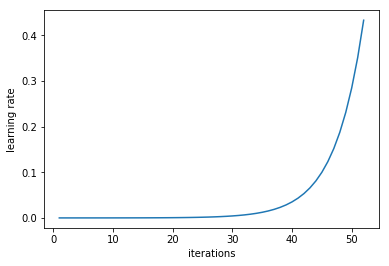

In [360]:
learn.sched.plot_lr()

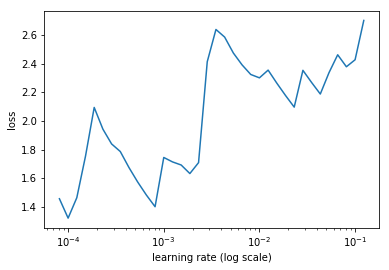

In [361]:
learn.sched.plot()

## Analyzing results: looking at pictures

As well as looking at the overall metrics, it's also a good idea to look at examples of each of:
1. A few correct labels at random
2. A few incorrect labels at random
3. The most correct labels of each class (i.e. those with highest probability that are correct)
4. The most incorrect labels of each class (i.e. those with highest probability that are incorrect)
5. The most uncertain labels (i.e. those with probability closest to 0.5).

In [362]:
# This is the label for a validation data
print(len(data.val_y), len(data.trn_y))  # 32 samples in val, 132 in train
data.val_y

32 132


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [363]:
# So, how fastai handles it is that validation data is put aside from the "train"

In [364]:
data.classes   # elephant = 0, rhino = 1

['elephant', 'rhino']

In [365]:
# this gives prediction for the validation set. Predictions are in log scale
log_preds = learn.predict()  # Looks automatically at the validation set that was not used for training
log_preds.shape

(32, 2)

In [366]:
# log probabilities for the classes:
log_preds[:10]

array([[ -0.00117,  -6.75519],
       [ -1.27049,  -0.32947],
       [ -3.62586,  -0.02699],
       [ -0.00124,  -6.69627],
       [ -0.75203,  -0.63754],
       [ -1.71519,  -0.19836],
       [-12.53728,  -0.     ],
       [ -0.19988,  -1.70832],
       [-14.95771,  -0.     ],
       [ -0.00001, -11.96072]], dtype=float32)

In [367]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to predicted class label of 0 (ele) or 1 (rhino)
# argmax Returns the indices of the maximum values along an axis. Now for rows.

probs = np.exp(log_preds[:,1])        # pr(rhino)

In [368]:
# Chooses four indices at random (where mask is nonzero)
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
# Generates a random sample from a given 1-D array. Size = 4, without replacement. Returns ndarray

# np.where: Return elements, either from `x` or `y`, depending on `condition`. x if true, else y.
# When only condition is provided, this function is a shorthand for np.asarray(condition).nonzero().


# Valitsee neljä indeksiä satunnaisesti oikein ennustettujen joukosta
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y) == is_correct)

In [369]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):  # 
        sp = f.add_subplot(rows, len(ims)//rows, i+1)    # //: Floor division
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])   # Display an image on the axes ( in the subplot)

In [370]:
import PIL.Image

def load_img_id(ds, idx): return np.array(Image.open(PATH + ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds, x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

In [371]:
# 1. A few correctly predicted ones at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")    # rand_by_correct(True) => Correctly predicted

Correctly classified


Incorrectly classified


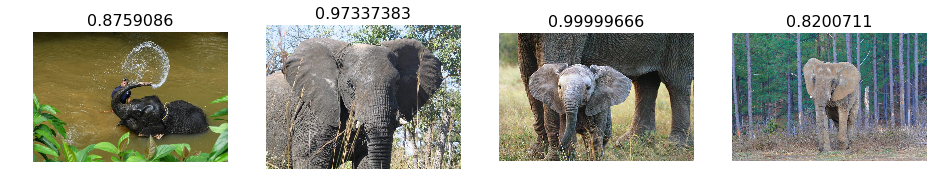

In [372]:
# 2. A few incorrect predictions at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [373]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]   #    If only `condition` is given, return the tuple ``condition.nonzero()``, the indices where `condition` is True.
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct elephants


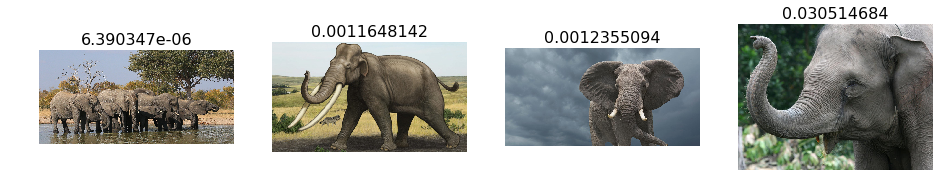

In [374]:
plot_val_with_title(most_by_correct(0, True), "Most correct elephants")   # Label 0 = elephant

Most correct rhinos


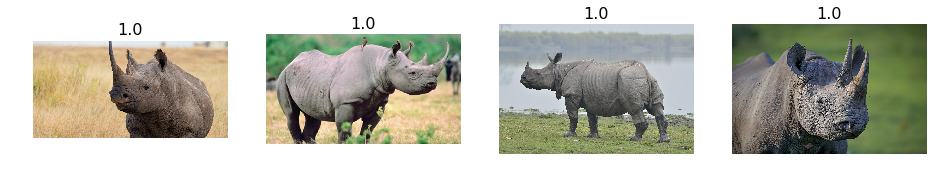

In [375]:
plot_val_with_title(most_by_correct(1, True), "Most correct rhinos")   # Label 1 = rhino

In [376]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect elephants")

Most incorrect elephants


Most incorrect rhinos


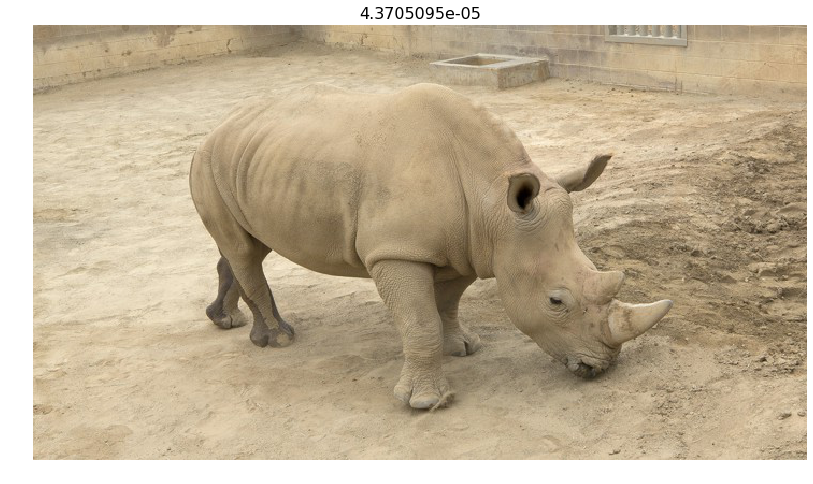

In [377]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect rhinos")

Most uncertain predictions


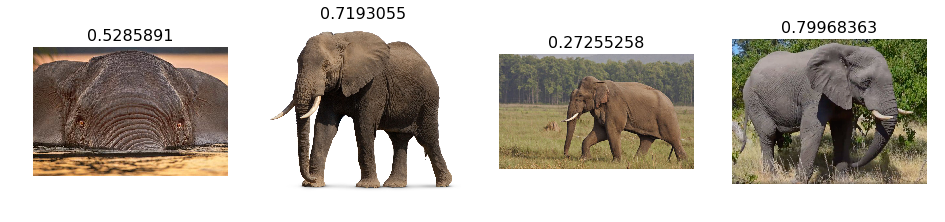

In [378]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4] 
plot_val_with_title(most_uncertain, "Most uncertain predictions")

## Choosing a learning rate

The *learning rate* determines how quickly or how slowly you want to update the *weights* (or *parameters*). Learning rate is one of the most difficult parameters to set, because it significantly affects model performance.

The method `learn.lr_find()` helps you find an optimal learning rate. It uses the technique developed in the 2015 paper [Cyclical Learning Rates for Training Neural Networks](http://arxiv.org/abs/1506.01186), where we simply keep increasing the learning rate from a very small value, until the loss stops decreasing. We can plot the learning rate across batches to see what this looks like.

We first create a new learner, since we want to know how to set the learning rate for a new (untrained) model.

In [379]:
learn = ConvLearner.pretrained(arch, data, precompute=True, tmp_name=TMP_PATH, models_name=MODEL_PATH)

In [380]:
lrf=learn.lr_find()

Our `learn` object contains an attribute `sched` that contains our learning rate scheduler, and has some convenient plotting functionality including this one:

In [381]:
learn.sched.plot_lr()

Note that in the previous plot *iteration* is one iteration (or *minibatch*) of SGD. In one epoch there are 
(num_train_samples/num_iterations) of SGD.

We can see the plot of loss versus learning rate to see where our loss stops decreasing:

In [382]:
learn.sched.plot()   # does not show a thing with the default bs=64 because so few samples in the dataset

The loss is still clearly improving at lr=1e-2 (0.01), so that's what we use. Note that the optimal learning rate can change as we train the model, so you may want to re-run this function from time to time.

## Improving our model

### Data augmentation

If you try training for more epochs, you'll notice that we start to *overfit*, which means that our model is learning to recognize the specific images in the training set, rather than generalizing such that we also get good results on the validation set. One way to fix this is to effectively create more data, through *data augmentation*. This refers to randomly changing the images in ways that shouldn't impact their interpretation, such as horizontal flipping, zooming, and rotating.

We can do this by passing `aug_tfms` (*augmentation transforms*) to `tfms_from_model`, with a list of functions to apply that randomly change the image however we wish. For photos that are largely taken from the side (e.g. most photos of dogs and cats, as opposed to photos taken from the top down, such as satellite imagery) we can use the pre-defined list of functions `transforms_side_on`. We can also specify random zooming of images up to specified scale by adding the `max_zoom` parameter.

In [383]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [384]:
def get_augs():
    data = ImageClassifierData.from_names_and_array(
        path=PATH, 
        fnames=fnames, 
        y=labels, 
        classes=['elephant', 'rhino'], 
        test_name='test/test/', 
        tfms=tfms,
        num_workers=1,
        bs=2
    )
    x,_ = next(iter(data.aug_dl))   # Return the next item from the iterator
    
    return data.trn_ds.denorm(x)[1]   # Reverse the normalization done to a batch of images.

In [385]:
ims = np.stack([get_augs() for i in range(6)])  # stack augmented images

# np.stack: Join a sequence of arrays along a new axis.
# The `axis` parameter specifies the index of the new axis in the dimensions
#of the result. For example, if ``axis=0`` it will be the first dimension and if ``axis=-1`` it will be the last dimension.
# default = 0 = first


In [386]:
# See some of the augmented images:
plots(ims, rows=2)

Let's create a new `data` object that includes this augmentation in the transforms.

In [387]:
# Sort of continuous process starts here:

data = ImageClassifierData.from_names_and_array(
    path=PATH, 
    fnames=fnames, 
    y=labels, 
    classes=['elephant', 'rhino'], 
    test_name='test/test', 
    tfms=tfms   # image transformation definitions
)
learn = ConvLearner.pretrained(arch, data, precompute=True, tmp_name=TMP_PATH, models_name=MODEL_PATH)

In [388]:
learn.fit(7e-3, 1)  # for 1 epoch


epoch      trn_loss   val_loss   accuracy        
    0      0.630842   0.830746   0.5       


[0.8307455778121948, 0.5]

Lets then move towards training the earlier layers as well...

In [389]:
learn.precompute=False   # to allow image transformations

By default when we create a learner, it sets all but the last layer to *frozen*. That means that it's still only updating the weights in the last layer when we call `fit`.

In [390]:
learn.fit(7e-3, 13, cycle_len=1)  # fit for some epochs


epoch      trn_loss   val_loss   accuracy                
    0      0.604181   0.585831   0.65625   
    1      0.60714    0.374299   0.875                   
    2      0.617127   0.256167   0.9375                  
    3      0.588371   0.174183   0.9375                  
    4      0.561673   0.133499   1.0                     
    5      0.492047   0.104463   1.0                     
    6      0.462675   0.086059   0.96875                 
    7      0.407461   0.0751     0.96875                 
    8      0.397741   0.057613   1.0                     
    9      0.360014   0.049168   1.0                     
    10     0.326395   0.044648   1.0                     
    11     0.303343   0.036146   1.0                     
    12     0.298407   0.034165   1.0                     


[0.03416530787944794, 1.0]

What is that `cycle_len` parameter? What we've done here is used a technique called *stochastic gradient descent with restarts (SGDR)*, a variant of *learning rate annealing*, which gradually decreases the learning rate as training progresses. This is helpful because as we get closer to the optimal weights, we want to take smaller steps.

However, we may find ourselves in a part of the weight space that isn't very resilient - that is, small changes to the weights may result in big changes to the loss. We want to encourage our model to find parts of the weight space that are both accurate and stable. Therefore, from time to time we increase the learning rate (this is the 'restarts' in 'SGDR'), which will force the model to jump to a different part of the weight space if the current area is "spikey". Here's a picture of how that might look if we reset the learning rates 3 times (in this paper they call it a "cyclic LR schedule"):

<img src="images/sgdr.png" width="80%">
(From the paper [Snapshot Ensembles](https://arxiv.org/abs/1704.00109)).

The number of epochs between resetting the learning rate is set by `cycle_len`, and the number of times this happens is refered to as the *number of cycles*, and is what we're actually passing as the 2nd parameter to `fit()`. So here's what our actual learning rates looked like:

In [391]:
learn.sched.plot_lr()

Our validation loss isn't improving much, so there's probably no point further training the last layer on its own.

Since we've got a pretty good model at this point, we might want to save it so we can load it again later without training it from scratch.

In [392]:
learn.save('224_lastlayer_elerhin')

In [393]:
learn.load('224_lastlayer_elerhin')

### Fine-tuning and differential learning rate annealing

Now that we have a good final layer trained, we can try fine-tuning the other layers. To tell the learner that we want to unfreeze the remaining layers, just call (surprise surprise!) `unfreeze()`.

In [394]:
learn.unfreeze()

Note that the other layers have *already* been trained to recognize imagenet photos (whereas our final layers where randomly initialized), so we want to be careful of not destroying the carefully tuned weights that are already there.

Generally speaking, the earlier layers (as we've seen) have more general-purpose features. Therefore we would expect them to need less fine-tuning for new datasets. For this reason we will use different learning rates for different layers: the first few layers will be at 1e-4, the middle layers at 1e-3, and our FC layers we'll leave at 1e-2 as before [**Made these a little smaller**]. We refer to this as *differential learning rates*, although there's no standard name for this techique in the literature that we're aware of.

In [395]:
#lr=np.array([5e-5, 5e-4, 7e-3])
lr=np.array([5e-6, 5e-5, 5e-4])

In [396]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)  # did not seme to help in this case


epoch      trn_loss   val_loss   accuracy                
    0      0.220341   0.04746    1.0       
    1      0.195182   0.060837   0.96875                 
    2      0.176912   0.064977   0.96875                 
    3      0.166635   0.059561   1.0                     
    4      0.189602   0.063743   0.96875                 
    5      0.173862   0.072905   0.96875                 
    6      0.198596   0.061293   1.0                     


[0.0612928569316864, 1.0]

Another trick we've used here is adding the `cycle_mult` parameter. Take a look at the following chart, and see if you can figure out what the parameter is doing:

In [397]:
learn.sched.plot_lr()

Note that's what being plotted above is the learning rate of the *final layers*. The learning rates of the earlier layers are fixed at the same multiples of the final layer rates as we initially requested (i.e. the first layers have 100x smaller, and middle layers 10x smaller learning rates, since we set `lr=np.array([1e-4,1e-3,1e-2])`.

In [398]:
learn.save('224_all_elerhin')

In [399]:
learn.load('224_all_elerhin')

There is something else we can do with data augmentation: use it at *inference* time (also known as *test* time). Not surprisingly, this is known as *test time augmentation*, or just *TTA*.

TTA simply makes predictions not just on the images in your validation set, but also makes predictions on a number of randomly augmented versions of them too (by default, it uses the original image along with 4 randomly augmented versions). It then takes the average prediction from these images, and uses that. To use TTA on the validation set, we can use the learner's `TTA()` method.

In [400]:
log_preds, y = learn.TTA()  # on the validation set
probs = np.mean(np.exp(log_preds), 0)

In [401]:
accuracy_np(probs, y)

1.0

I generally see about a 10-20% reduction in error on this dataset when using TTA at this point, which is an amazing result for such a quick and easy technique!

## Analyzing results

### Confusion matrix 

In [402]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

A common way to analyze the result of a classification model is to use a [confusion matrix](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/). Scikit-learn has a convenient function we can use for this purpose:

In [403]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

We can just print out the confusion matrix, or we can show a graphical view (which is mainly useful for dependents with a larger number of categories).

In [404]:
plot_confusion_matrix(cm, data.classes)  # got (almost) everything right

[[16  0]
 [ 0 16]]


### Looking at pictures again

In [405]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect elephants")

Most incorrect elephants


<Figure size 1152x576 with 0 Axes>

In [406]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect rhinos")

Most incorrect rhinos


<Figure size 1152x576 with 0 Axes>

## Review: easy steps to train a world-class image classifier

1. precompute=True
1. Use `lr_find()` to find highest learning rate where loss is still clearly improving
1. Train last layer from precomputed activations for 1-2 epochs
1. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
1. Unfreeze all layers
1. Set earlier layers to 3x-10x lower learning rate than next higher layer
1. Use `lr_find()` again
1. Train full network with cycle_mult=2 until over-fitting

In [407]:
# need to apply transformations
#trn_tfms, val_tfms = tfms_from_model(arch, sz)
trn_tfms, val_tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

def predictSingleImage(fn, IMGPATH = PATH + "test/test/"):
    im = val_tfms(open_image(IMGPATH+fn)) # Load Image using fastai open_image in dataset.py
    learn.precompute=False # We’ll pass in a raw image, not activations
    log_preds_single = learn.predict_array(im[None]) # Predict Image
    maxP = np.argmax(log_preds_single, axis=1) # Pick the index with highest log probability
    probs_single = np.exp(log_preds_single) # If you want the probabilities of the classes
    print("Prediction:\t", probs_single)
    actualclass = data.classes[maxP[0]] # Look up tactualPT   return actualclass
    print("Predicted: ", actualclass)
    return actualclass

Prediction:	 [[0.04741 0.95259]]
Predicted:  rhino


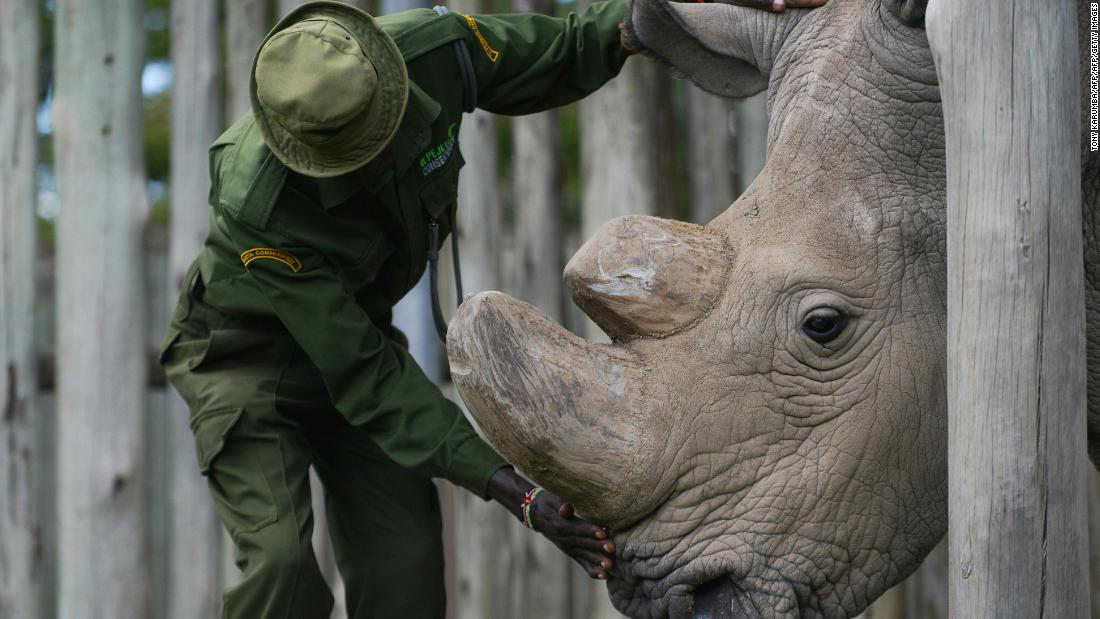

In [408]:
TEST_PATH = PATH + "test/test/"  # data not used for training
test_img_files = os.listdir(TEST_PATH)

img_id = 9

predictSingleImage(test_img_files[img_id])
#rint("True label:\t", labels_test[img_id])

Image.open(TEST_PATH + test_img_files[img_id])#.resize((150,150))
# True:17     False: 1 (id 20)    Jaa-a: 1   Kuva puuttui muutamista

In [409]:
# Lets predict a couple of still new pics (individual prediction)
path_to_ind_test =  "../input/fewtestpics/"

os.listdir(path_to_ind_test)

['rhino3.jpg',
 'rhino.jpg',
 'ele3.jpg',
 'ele2.jpg',
 'rhino2.jpg',
 'elephant_test.jpg',
 'rhino_test.jpg',
 'ele.jpg',
 'elephant_test2.jpg',
 'rhino_test2.jpg']

In [410]:
individual_test_fns = [path_to_ind_test + file for file in os.listdir(path_to_ind_test)]
individual_test_fns

['../input/fewtestpics/rhino3.jpg',
 '../input/fewtestpics/rhino.jpg',
 '../input/fewtestpics/ele3.jpg',
 '../input/fewtestpics/ele2.jpg',
 '../input/fewtestpics/rhino2.jpg',
 '../input/fewtestpics/elephant_test.jpg',
 '../input/fewtestpics/rhino_test.jpg',
 '../input/fewtestpics/ele.jpg',
 '../input/fewtestpics/elephant_test2.jpg',
 '../input/fewtestpics/rhino_test2.jpg']

../input/fewtestpics/rhino3.jpg


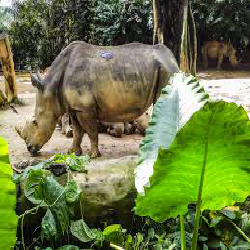

In [411]:
testpic_id = 0
print(individual_test_fns[testpic_id])
Image.open(individual_test_fns[testpic_id]).resize((250,250))

In [412]:
#!pip install Pillow --upgrade
#!pip install PIL --upgrade
#!pip install image --upgrade


In [413]:
import PIL
import PIL.Image

In [414]:
# need to apply transformations
#trn_tfms, val_tfms = tfms_from_model(arch, sz)

trn_tfms, val_tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

Testing with fn:  elephant_test2.jpg
Prediction:	 [[0.98721 0.01279]]
Predicted:  elephant


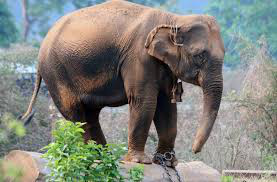

In [415]:
# TESTING SINGLE IMAGES:
FOLDER_FOR_A_FEW_MORE_TEST_PICS = '../input/fewtestpics/'

testpic_id = 8  # 0...9
testpic_fn = os.path.basename(individual_test_fns[testpic_id])
print("Testing with fn: ", testpic_fn)

predictSingleImage(testpic_fn, FOLDER_FOR_A_FEW_MORE_TEST_PICS)

Image.open(individual_test_fns[testpic_id])

## Understanding the code for our first model

**tfms** stands for *transformations*. `tfms_from_model` takes care of resizing, image cropping, initial normalization (creating data with (mean,stdev) of (0,1)), and more.

In [ ]:
tfms = tfms_from_model(resnet34, sz)

We need a <b>path</b> that points to the dataset. In this path we will also store temporary data and final results. `ImageClassifierData.from_names_and_array` takes in the names of the image files as well as an array of ground-truth labels and creates a dataset ready for training.

In [ ]:
data = ImageClassifierData.from_names_and_array(
    path=PATH, 
    fnames=fnames, 
    y=labels, 
    classes=['elephant', 'rhino'], 
    test_name='test', 
    tfms=tfms
)

`ConvLearner.pretrained` builds *learner* that contains a pre-trained model. The last layer of the model needs to be replaced with the layer of the right dimensions. The pretained model was trained for 1000 classes therfore the final layer predicts a vector of 1000 probabilities. The model for cats and dogs needs to output a two dimensional vector. The diagram below shows in an example how this was done in one of the earliest successful CNNs. The layer "FC8" here would get replaced with a new layer with 2 outputs.

<img src="https://image.slidesharecdn.com/practicaldeeplearning-160329181459/95/practical-deep-learning-16-638.jpg" width="500">
[original image](https://image.slidesharecdn.com/practicaldeeplearning-160329181459/95/practical-deep-learning-16-638.jpg)

In [ ]:
learn = ConvLearner.pretrained(resnet34, data, precompute=True, tmp_name=TMP_PATH, models_name=MODEL_PATH)

*Parameters*  are learned by fitting a model to the data. *Hyperparameters* are another kind of parameter, that cannot be directly learned from the regular training process. These parameters express “higher-level” properties of the model such as its complexity or how fast it should learn. Two examples of hyperparameters are the *learning rate* and the *number of epochs*.

During iterative training of a neural network, a *batch* or *mini-batch* is a subset of training samples used in one iteration of Stochastic Gradient Descent (SGD). An *epoch* is a single pass through the entire training set which consists of multiple iterations of SGD.

We can now *fit* the model; that is, use *gradient descent* to find the best parameters for the fully connected layer we added, that can separate cat pictures from dog pictures. We need to pass two hyperameters: the *learning rate* (generally 1e-2 or 1e-3 is a good starting point, we'll look more at this next) and the *number of epochs* (you can pass in a higher number and just stop training when you see it's no longer improving, then re-run it with the number of epochs you found works well.)

In [ ]:
learn.fit(1e-2, 1)

## Analyzing results: loss and accuracy

When we run `learn.fit` we print 3 performance values (see above.) Here 0.03 is the value of the **loss** in the training set, 0.0226 is the value of the loss in the validation set and 0.9927 is the validation accuracy. What is the loss? What is accuracy? Why not to just show accuracy?

**Accuracy** is the ratio of correct prediction to the total number of predictions.

In machine learning the **loss** function or cost function is representing the price paid for inaccuracy of predictions.

The loss associated with one example in binary classification is given by:
`-(y * log(p) + (1-y) * log (1-p))`
where `y` is the true label of `x` and `p` is the probability predicted by our model that the label is 1.

In [ ]:
def binary_loss(y, p):
    return np.mean(-(y * np.log(p) + (1-y)*np.log(1-p)))

In [ ]:
acts = np.array([1, 0, 0, 1])
preds = np.array([0.9, 0.1, 0.2, 0.8])
binary_loss(acts, preds)

Note that in our toy example above our accuracy is 100% and our loss is 0.16. Exercise: play with `preds` to get a lower loss for this example. 

**Example:** Here is an example on how to compute the loss for one example of binary classification problem. Suppose for an image x with label 1 and your model gives it a prediction of 0.9. For this case the loss should be small because our model is predicting a label $1$ with high probability.

`loss = -log(0.9) = 0.10`

Now suppose x has label 0 but our model is predicting 0.9. In this case our loss should be much larger.

loss = -log(1-0.9) = 2.30

- Exercise: look at the other cases and convince yourself that this make sense.
- Exercise: how would you rewrite `binary_loss` using `if` instead of `*` and `+`?

Why not just maximize accuracy? The binary classification loss is an easier function to optimize.